# **Forest Fire Prediction**

### Part 3: Gathering data from wether API

In [43]:
# Please note if running on a clean environment, need to install missing modules

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
%matplotlib inline

pd.options.mode.chained_assignment = None

In [44]:
API_URL = 'https://archive-api.open-meteo.com/v1/archive'

FINAL_AFTER_PREP_CSV = 'fire_history_prep.csv'
ADD_WEATHER_CSV = 'fire_history_with_weather.csv'
#WEATHER_OUTLIERS_CSV = 'fire_history_weather_outliers_removed.csv'

FINAL_CSV = 'fire_history_final.csv'

PARAMETERS = ['temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max', 'winddirection_10m_dominant', 'shortwave_radiation_sum', 'precipitation_sum']
WEATHER_COLS = ['MaxTemperature', 'MinTemperature', 'WindSpeed', 'WindDirection', 'Radiation', 'Precipitation']

In [3]:
def get_weather(latitude, longitude, date):
    params = {'latitude': latitude, 'longitude': longitude, 'start_date': date, 'end_date': date, 
              'daily': PARAMETERS, 'mim': date, 'max': date, 'timezone': 'GMT'}
    response = requests.get(API_URL, params=params)
    if response.status_code == 200:
        return response.json()['daily']
    else:
        return None

In [4]:
def add_weather_data(df):
    df_updated = df.copy()
    df_updated[WEATHER_COLS] = np.nan

    lats = df_updated['InitialLatitude'].tolist()
    longs = df_updated['InitialLongitude'].tolist()
    dates = df_updated['FireDiscoveryDateTime'].tolist()

    final_data = [get_weather(lat, lon, date) for lat, lon, date in zip(lats, longs, dates)]

    for row in df_updated.index:
        for i in range(len(WEATHER_COLS)):
            df_updated[WEATHER_COLS[i]][row] = final_data[row][PARAMETERS[i]][0]

    return df_updated

In [5]:
def remove_outliers(df, outliers):
    for row in df.index:
        if outliers[row] == True:
            df.drop(row, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [42]:
def weather_outliers(df):
    df_cleaned = df.copy()
    check_cols = ['MaxTemperature', 'MinTemperature',
                  'WindSpeed', 'Radiation', 'Precipitation']

    for col in check_cols:
        outliers = []
        data = df_cleaned[col]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        for x in data:
            if x < lower_bound or x > upper_bound:
                outliers.append(True)
            else:
                outliers.append(False)

        df_cleaned = remove_outliers(df_cleaned, outliers)

    return df_cleaned

In [7]:
def boxplot_outliers(df, df2):
    # Set up the subplots
    fig, axes = plt.subplots(1, 6, figsize=(15, 7))
    ylabels = ['Maximum daily air temperature at 2m above ground in °C',
               'Minimum daily air temperature at 2m above ground in °C',
               'Maximum wind speed on a day in km/h',
               'Dominant wind direction °',
               'The sum of solar radiation on a given day in MJ/m²',
               'Sum of daily precipitation in mm']

    # Create boxplots for each column
    for i, col in enumerate(WEATHER_COLS):
        axes[i].boxplot([df[col], df2[col]], labels=['Before', 'After'])
        axes[i].set_title(col + ' Boxplot')
        axes[i].set_ylabel(ylabels[i])
        axes[i].grid(True)

    plt.suptitle('Weather outliers:')
    plt.tight_layout()
    plt.show()

In [8]:
df = pd.read_csv(FINAL_AFTER_PREP_CSV)
df

,UniqueFireIdentifier,FireDiscoveryDateTime,FireOutDateTime,InitialLatitude,InitialLongitude,POOCounty,FireCause,FireDuration,CausedByWeather
0,2022-COUMA-000926,2022-08-09,2022-08-15,37.178610,-108.889100,Montezuma,2,6,1
1,2022-PAPAS-001588,2022-11-09,2022-11-10,41.700000,-79.031000,Warren,1,1,0
2,2022-ORNOD-220301,2022-08-17,2022-08-17,43.831530,-122.733900,Lane,1,0,0
3,2022-ORNOD-220285,2022-08-13,2022-08-14,43.837670,-122.773600,Lane,1,1,0
4,2022-ORBENN-000436,2022-07-26,2022-07-26,44.007700,-121.223700,Deschutes,1,0,0
...,...,...,...,...,...,...,...,...,...
83421,2023-IDBOD-000349,2023-06-18,2023-06-20,43.330760,-116.409500,Ada,1,2,0
83422,2023-CASNF-000573,2023-06-18,2023-06-19,37.568056,-119.843889,Mariposa,4,1,0
83423,2023-AZA5S-230819,2023-06-18,2023-06-19,35.892840,-114.087600,Mohave,1,1,0
83424,2023-AZA3S-230824,2023-06-19,2023-06-19,32.645000,-111.392900,Pinal,1,0,0


In [6]:
df = add_weather_data(df)
#df = pd.read_csv(ADD_WEATHER_CSV)
df.to_csv(ADD_WEATHER_CSV, index=False)
df

,UniqueFireIdentifier,FireDiscoveryDateTime,FireOutDateTime,InitialLatitude,InitialLongitude,POOCounty,FireCause,FireDuration,CausedByWeather,MaxTemperature,MinTemperature,WindSpeed,WindDirection,Radiation,Precipitation
0,2022-COUMA-000926,2022-08-09,2022-08-15,37.178610,-108.889100,Montezuma,2,6,1,33.4,19.2,21.1,311.0,27.67,0.0
1,2022-PAPAS-001588,2022-11-09,2022-11-10,41.700000,-79.031000,Warren,1,1,0,14.1,2.1,15.9,326.0,11.43,0.0
2,2022-ORNOD-220301,2022-08-17,2022-08-17,43.831530,-122.733900,Lane,1,0,0,35.0,14.2,12.8,86.0,24.29,0.0
3,2022-ORNOD-220285,2022-08-13,2022-08-14,43.837670,-122.773600,Lane,1,1,0,26.3,11.8,13.1,140.0,26.21,0.0
4,2022-ORBENN-000436,2022-07-26,2022-07-26,44.007700,-121.223700,Deschutes,1,0,0,37.2,17.1,11.6,131.0,30.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83421,2023-IDBOD-000349,2023-06-18,2023-06-20,43.330760,-116.409500,Ada,1,2,0,25.8,14.3,19.6,274.0,19.84,1.9
83422,2023-CASNF-000573,2023-06-18,2023-06-19,37.568056,-119.843889,Mariposa,4,1,0,26.0,13.7,12.2,223.0,28.97,0.0
83423,2023-AZA5S-230819,2023-06-18,2023-06-19,35.892840,-114.087600,Mohave,1,1,0,33.2,20.5,26.1,195.0,31.45,0.0
83424,2023-AZA3S-230824,2023-06-19,2023-06-19,32.645000,-111.392900,Pinal,1,0,0,39.4,24.3,29.1,225.0,30.54,0.0


In [9]:
print("DataFrame information:")
df.info()
print()
print("DataFrame description:")
df.describe(include='all')

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83426 entries, 0 to 83425
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UniqueFireIdentifier   83426 non-null  object 
 1   FireDiscoveryDateTime  83426 non-null  object 
 2   FireOutDateTime        83426 non-null  object 
 3   InitialLatitude        83426 non-null  float64
 4   InitialLongitude       83426 non-null  float64
 5   POOCounty              83426 non-null  object 
 6   FireCause              83426 non-null  int64  
 7   FireDuration           83426 non-null  int64  
 8   CausedByWeather        83426 non-null  int64  
 9   MaxTemperature         83426 non-null  float64
 10  MinTemperature         83426 non-null  float64
 11  WindSpeed              83426 non-null  float64
 12  WindDirection          83426 non-null  float64
 13  Radiation              83426 non-null  float64
 14  Precipitation          83426 no

,UniqueFireIdentifier,FireDiscoveryDateTime,FireOutDateTime,InitialLatitude,InitialLongitude,POOCounty,FireCause,FireDuration,CausedByWeather,MaxTemperature,MinTemperature,WindSpeed,WindDirection,Radiation,Precipitation
count,83426,83426,83426,83426.000000,83426.000000,83426,83426.000000,83426.000000,83426.000000,83426.000000,83426.000000,83426.000000,83426.000000,83426.000000,83426.000000
unique,83426,3189,3194,NaN,NaN,976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-COUMA-000926,2020-07-05,2021-07-05,NaN,NaN,Coconino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,258,163,NaN,NaN,1848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,40.557980,-109.908788,NaN,1.727315,4.892791,0.268501,25.284182,12.049096,16.399824,204.939539,23.144037,0.863292
std,NaN,NaN,NaN,6.594656,12.933619,NaN,0.994427,5.755790,0.443183,8.208251,7.476020,6.777346,88.950697,6.159196,2.676969
min,NaN,NaN,NaN,25.136111,-167.075908,NaN,1.000000,0.000000,0.000000,-20.600000,-28.400000,2.400000,0.000000,0.100000,0.000000
25%,NaN,NaN,NaN,35.203945,-116.987375,NaN,1.000000,1.000000,0.000000,19.900000,7.100000,11.600000,154.000000,19.520000,0.000000
50%,NaN,NaN,NaN,40.108000,-111.582950,NaN,1.000000,3.000000,0.000000,26.400000,12.800000,15.000000,218.000000,24.360000,0.000000
75%,NaN,NaN,NaN,45.099650,-105.086100,NaN,2.000000,7.000000,1.000000,31.400000,17.200000,19.800000,271.000000,27.850000,0.400000


in order to transpose nominal scale data to numerical scale

In [27]:
df = pd.read_csv(ADD_WEATHER_CSV)
check_cols = ['MaxTemperature', 'MinTemperature',
              'WindSpeed', 'Radiation', 'Precipitation']
weather_df = df[check_cols].copy()

weather_df['Month'] = pd.DatetimeIndex(df['FireDiscoveryDateTime']).month
weather_df['Location'] = df['POOCounty']

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# imputation
#imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=True)
# standard scaler
ss = preprocessing.StandardScaler()
ss_columns = check_cols

monthly_weathers = {}
for i in range(1, 13, 1):
    monthly_weathers[i] = weather_df.query("Month=={0}".format(i))
    monthly_weathers[i].reset_index(inplace=True, drop=True)

for m, w in monthly_weathers.items():
    # finding if there's null value
    # has_null = [c for c in check_cols if len(w[w[c].isnull()]) > 0]
    # if has_null != []:
    #     # impute null values
    #     w_with_nan = w[has_null]
    #     imp_w = imp.fit_transform(w_with_nan).T
    #     for i in range(len(has_null)):
    #         # replace columns with null to the imputed
    #         w[has_null[i]] = imp_w[i]
    #         if len(w[w[has_null[i]].isnull()]) > 0:
    #             print(has_null[i], len(w[w[has_null[i]].isnull()]))
    # standard scaler
    w[ss_columns] = pd.DataFrame(ss.fit_transform(w[ss_columns]), columns=ss_columns)

    weather_df = pd.DataFrame.from_dict(monthly_weathers[])
weather_df


,MaxTemperature,MinTemperature,WindSpeed,Radiation,Precipitation,Month,Location
0,-1.122042,-1.472489,-0.953171,0.274253,-0.186942,1,Yavapai
1,0.862222,0.457136,-0.295385,1.309423,-0.186942,1,Angelina
2,0.173469,-0.683097,-0.902572,0.912975,-0.186942,1,Panola
3,-0.761267,-0.262088,-1.016420,-0.713720,0.670526,1,Bowie
4,0.567042,-0.227004,-0.902572,1.098614,-0.186942,1,Perry
...,...,...,...,...,...,...,...
1576,-1.007250,-1.261984,0.096757,0.947586,-0.186942,1,Nye
1577,-1.154840,0.141379,-1.155567,-3.007455,0.444876,1,Island
1578,-0.105312,0.351884,-0.409232,0.459892,-0.186942,1,Choctaw
1579,-2.499548,-1.612825,-1.509760,-2.441101,0.309487,1,Flathead


In [38]:
df = pd.read_csv(ADD_WEATHER_CSV)
ss_columns = ['MaxTemperature', 'MinTemperature',
              'WindSpeed', 'Radiation', 'Precipitation']
weather_df = df[check_cols].copy()

weather_df['Month'] = pd.DatetimeIndex(df['FireDiscoveryDateTime']).month
weather_df['Location'] = df['POOCounty']

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ss = preprocessing.StandardScaler()
weather_df[ss_columns] = pd.DataFrame(ss.fit_transform(df[ss_columns]), columns=ss_columns)
weather_df


,MaxTemperature,MinTemperature,WindSpeed,Radiation,Precipitation,Month,Location
0,0.988745,0.956518,0.693517,0.734835,-0.322491,8,Montezuma
1,-1.362562,-1.330809,-0.073750,-1.901889,-0.322491,11,Warren
2,1.183672,0.287709,-0.531159,0.186058,-0.322491,8,Lane
3,0.123756,-0.033320,-0.486893,0.497789,-0.322491,8,Lane
4,1.451697,0.675618,-0.708220,1.114757,-0.322491,7,Deschutes
...,...,...,...,...,...,...,...
83421,0.062842,0.301085,0.472190,-0.536443,0.387272,6,Ada
83422,0.087208,0.220828,-0.619689,0.945902,-0.322491,6,Mariposa
83423,0.964379,1.130408,1.431273,1.348555,-0.322491,6,Mohave
83424,1.719721,1.638703,1.873927,1.200807,-0.322491,6,Pinal


KeyError: 1

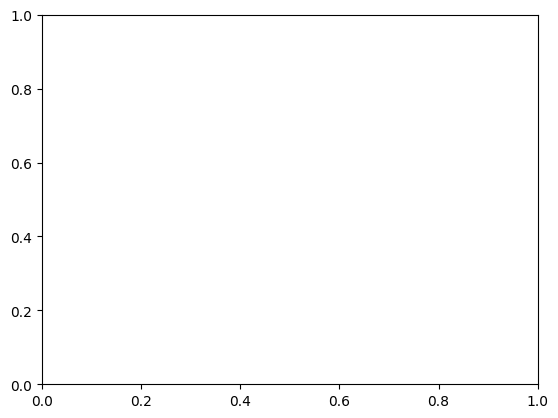

In [37]:
orig_monthly_weathers = {}
for i in range(1, 13, 1):
    orig_monthly_weathers[i] = weather_df.query("Month=={0}".format(i))
    orig_monthly_weathers[i].reset_index(inplace=True, drop=True)

# let's see if there are any outliers
for i in range(1, 13, 1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(np.array(weather_df[i][check_cols]))
    ax.set_xticklabels(check_cols)
    plt.title(months[i-1])
    plt.grid()
    plt.show()


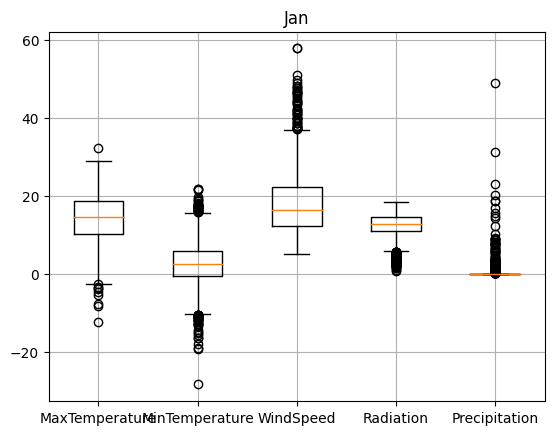

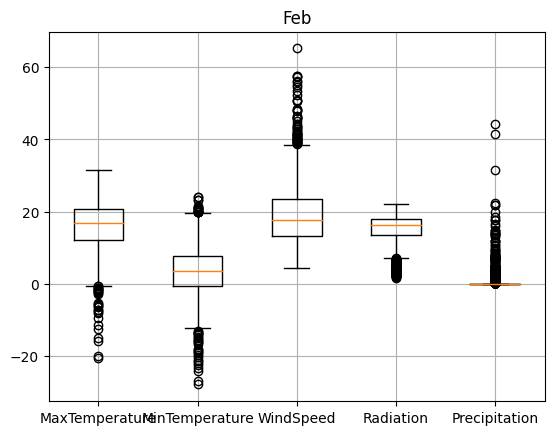

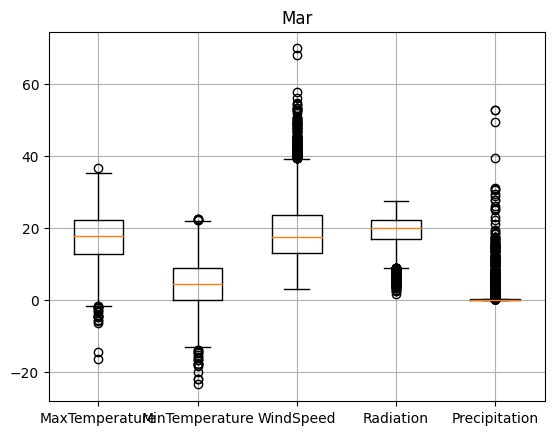

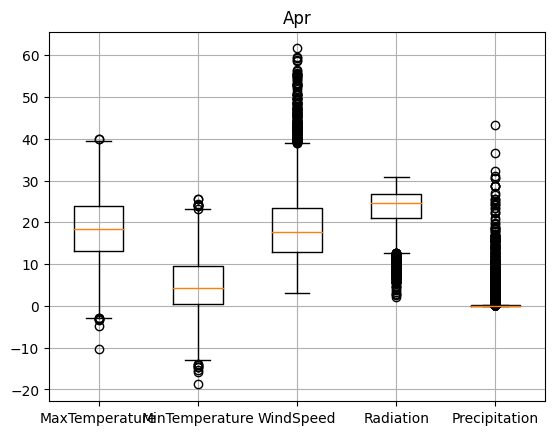

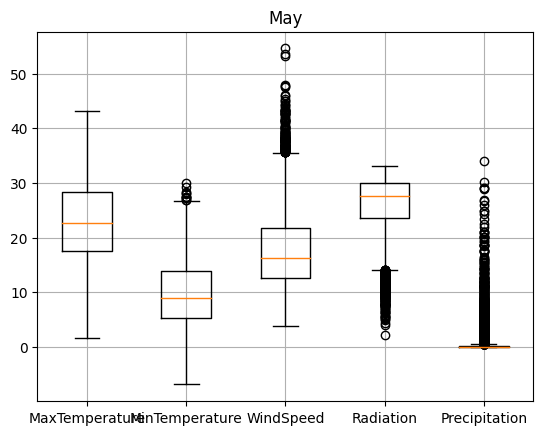

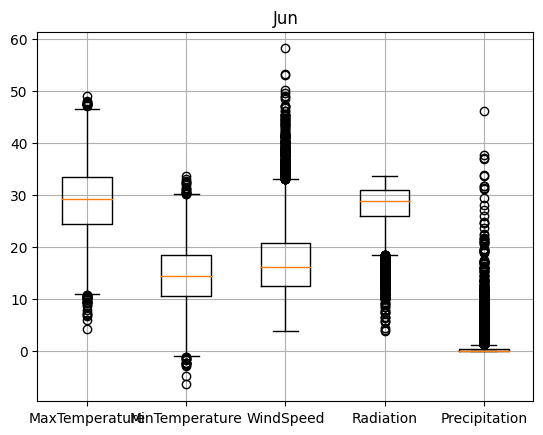

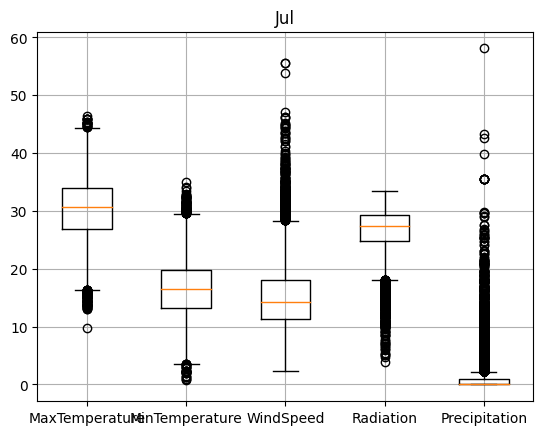

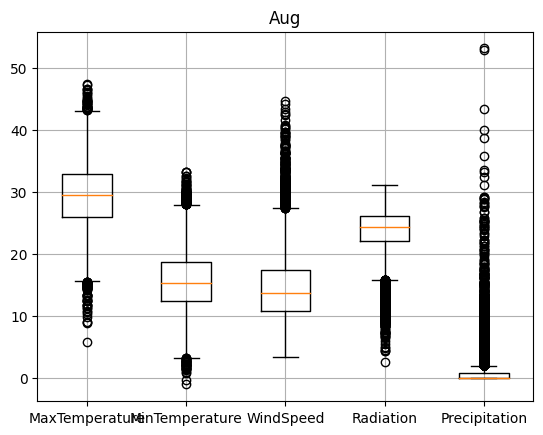

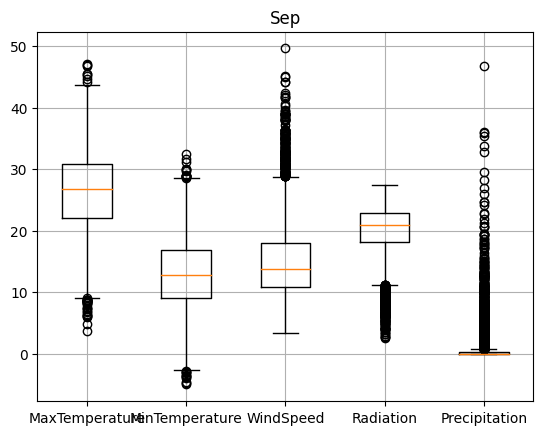

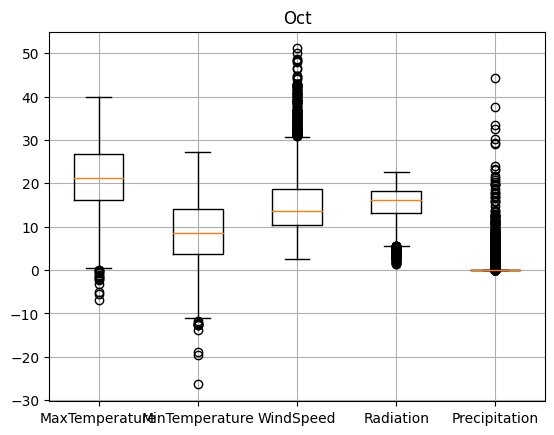

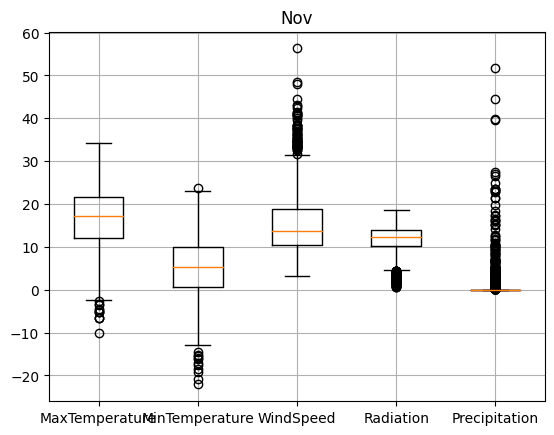

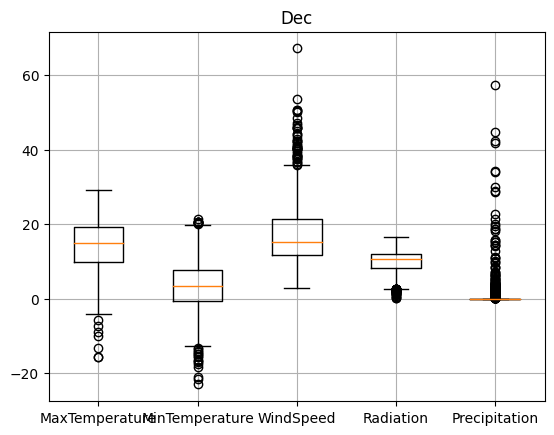

In [34]:
df = pd.read_csv(ADD_WEATHER_CSV)
check_cols = ['MaxTemperature', 'MinTemperature',
                'WindSpeed', 'Radiation', 'Precipitation']
weather_df = df[check_cols].copy()

weather_df['Month'] = pd.DatetimeIndex(df['FireDiscoveryDateTime']).month
weather_df['Location'] = df['POOCounty']

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# dividing the original dataset to monthly datasets
orig_monthly_weathers = {}
for i in range(1, 13, 1):
    orig_monthly_weathers[i] = weather_df.query("Month=={0}".format(i))
    orig_monthly_weathers[i].reset_index(inplace=True, drop=True)

# let's see if there are any outliers
for i in range(1,13,1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(np.array(orig_monthly_weathers[i][check_cols]))
    ax.set_xticklabels(check_cols)
    plt.title(months[i-1])
    plt.grid()
    plt.show()


In [45]:
df = pd.read_csv(ADD_WEATHER_CSV)
df2 = weather_outliers(df)
df2.to_csv(FINAL_CSV, index=False)
df2

,UniqueFireIdentifier,FireDiscoveryDateTime,FireOutDateTime,InitialLatitude,InitialLongitude,POOCounty,FireCause,FireDuration,CausedByWeather,MaxTemperature,MinTemperature,WindSpeed,WindDirection,Radiation,Precipitation
0,2022-COUMA-000926,2022-08-09,2022-08-15,37.178610,-108.889100,Montezuma,2,6,1,33.4,19.2,21.1,311.0,27.67,0.0
1,2022-PAPAS-001588,2022-11-09,2022-11-10,41.700000,-79.031000,Warren,1,1,0,14.1,2.1,15.9,326.0,11.43,0.0
2,2022-ORNOD-220301,2022-08-17,2022-08-17,43.831530,-122.733900,Lane,1,0,0,35.0,14.2,12.8,86.0,24.29,0.0
3,2022-ORNOD-220285,2022-08-13,2022-08-14,43.837670,-122.773600,Lane,1,1,0,26.3,11.8,13.1,140.0,26.21,0.0
4,2022-ORBENN-000436,2022-07-26,2022-07-26,44.007700,-121.223700,Deschutes,1,0,0,37.2,17.1,11.6,131.0,30.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65956,2023-NVLAP-500667,2023-06-18,2023-06-18,35.491400,-114.686000,Clark,4,0,0,40.2,27.6,26.4,189.0,30.97,0.0
65957,2023-MNSUF-000191,2023-06-18,2023-06-18,47.734210,-91.130360,Lake,4,0,0,22.9,12.4,14.1,152.0,25.47,0.0
65958,2023-CASNF-000573,2023-06-18,2023-06-19,37.568056,-119.843889,Mariposa,4,1,0,26.0,13.7,12.2,223.0,28.97,0.0
65959,2023-AZA5S-230819,2023-06-18,2023-06-19,35.892840,-114.087600,Mohave,1,1,0,33.2,20.5,26.1,195.0,31.45,0.0


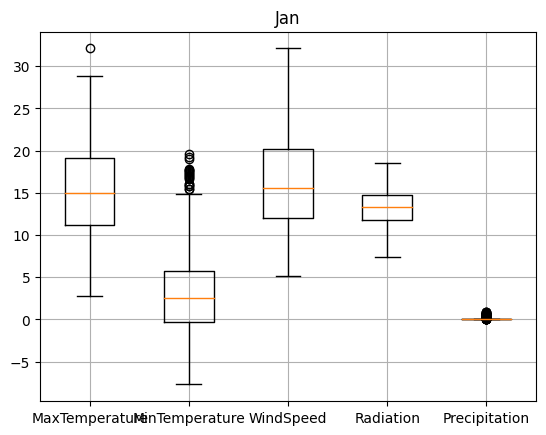

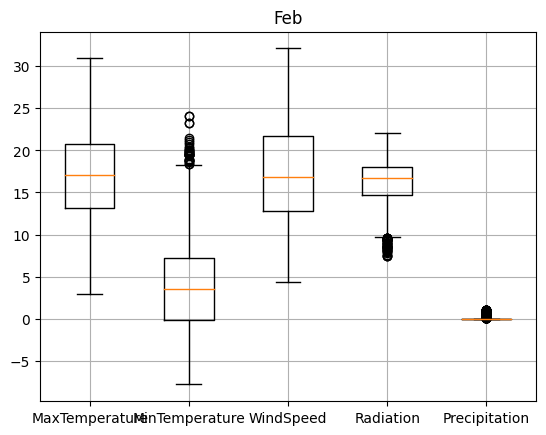

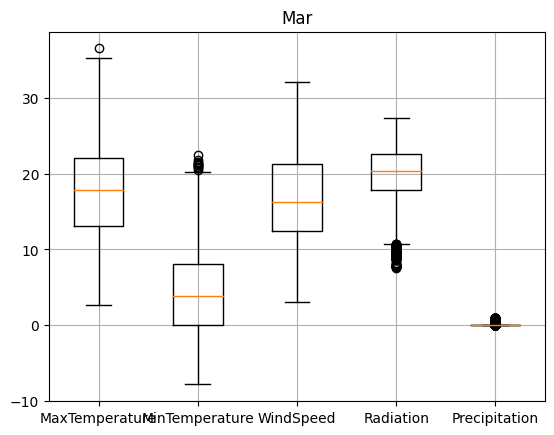

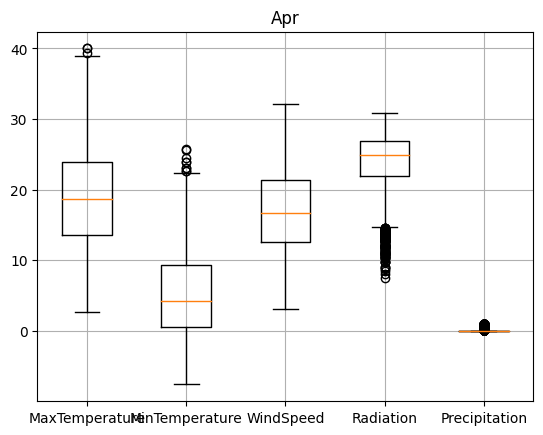

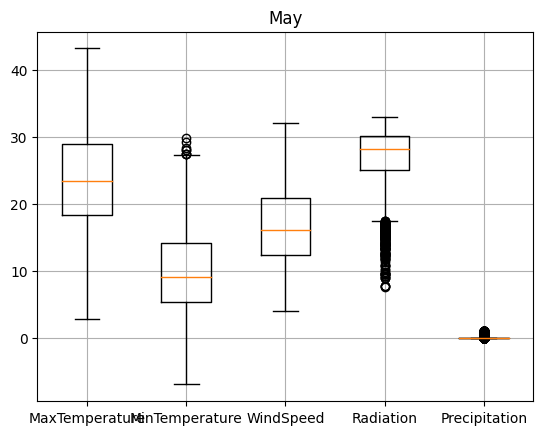

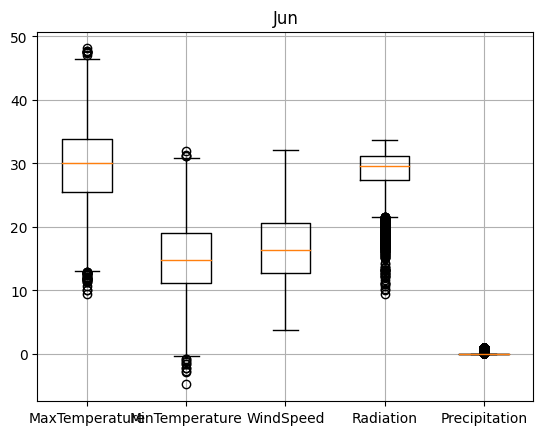

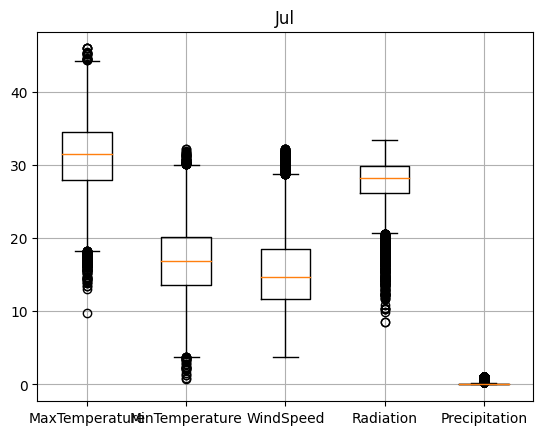

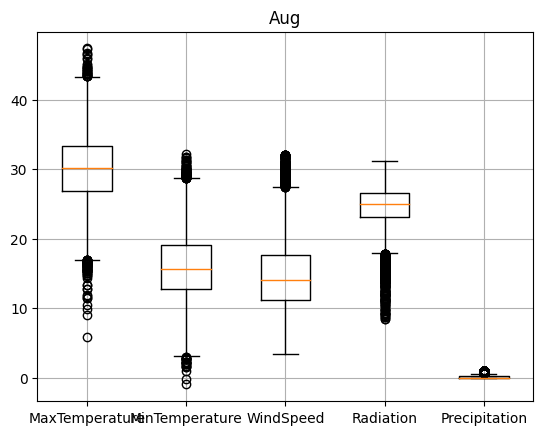

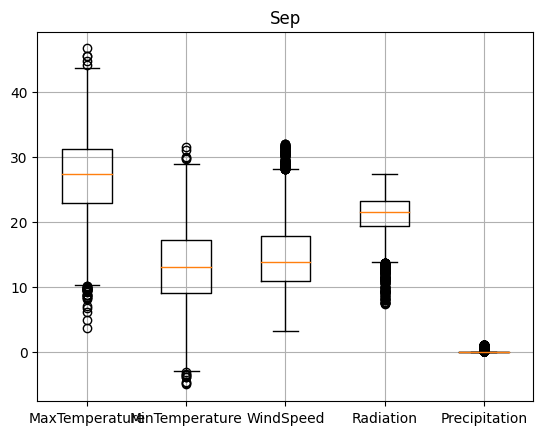

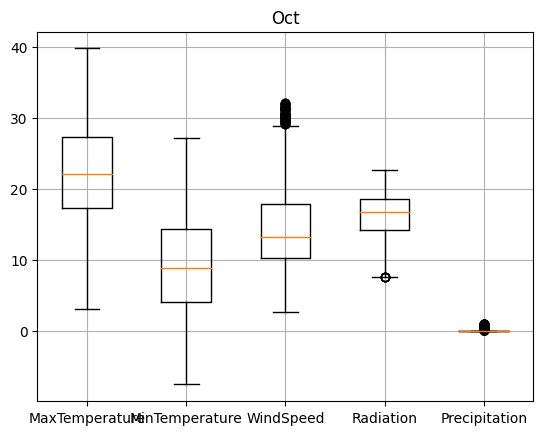

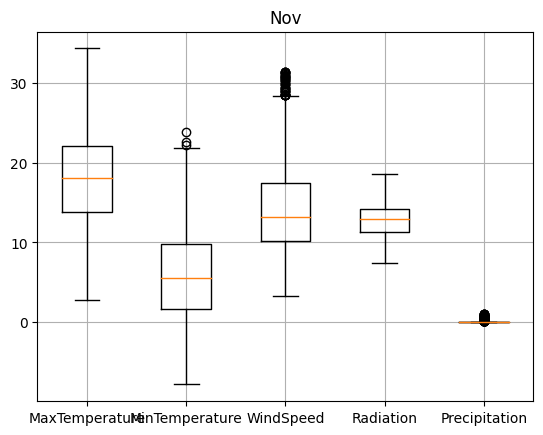

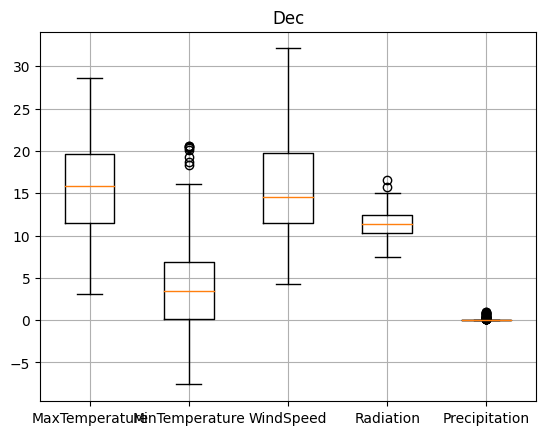

In [14]:

check_cols = ['MaxTemperature', 'MinTemperature',
              'WindSpeed', 'Radiation', 'Precipitation']
weather_df = df2[check_cols].copy()

weather_df['Month'] = pd.DatetimeIndex(df2['FireDiscoveryDateTime']).month
weather_df['Location'] = df['POOCounty']

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# dividing the original dataset to monthly datasets
orig_monthly_weathers = {}
for i in range(1, 13, 1):
    orig_monthly_weathers[i] = weather_df.query("Month=={0}".format(i))
    orig_monthly_weathers[i].reset_index(inplace=True, drop=True)

# let's see if there are any outliers
for i in range(1, 13, 1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(np.array(orig_monthly_weathers[i][check_cols]))
    ax.set_xticklabels(check_cols)
    plt.title(months[i-1])
    plt.grid()
    plt.show()


KeyError: 'WindDirection'

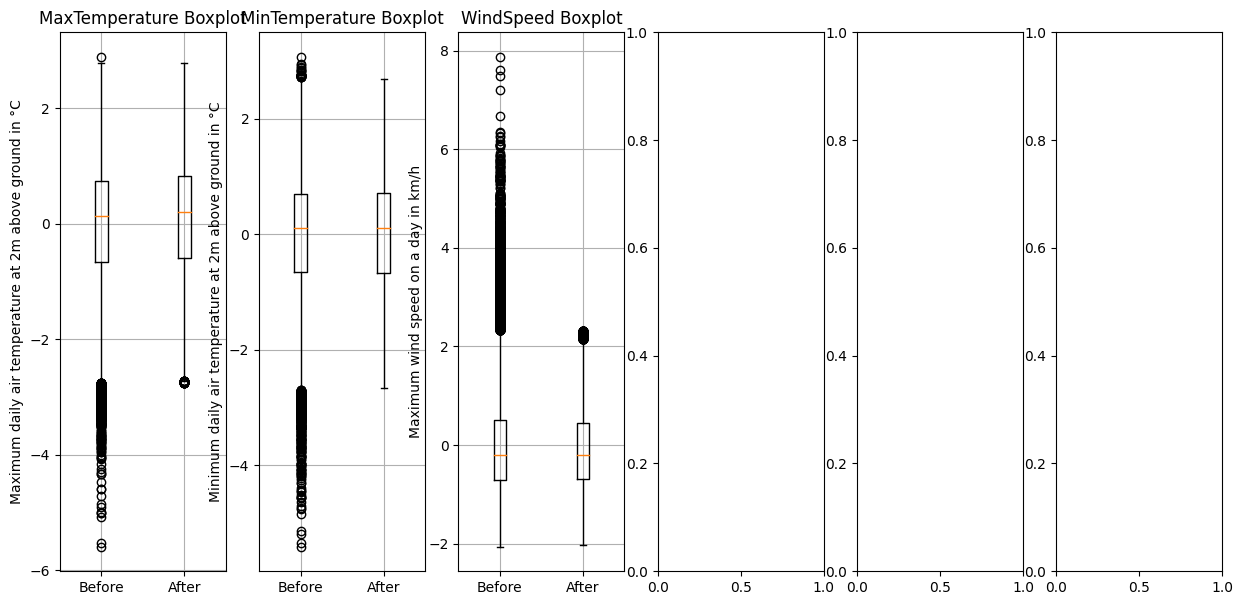

In [40]:
boxplot_outliers(weather_df, df2)